In [1]:
import numpy as np
import math as mt
import pandas as pd

### Метод подсчета exp суммированием ряда Тейлора

In [5]:
# EXP
def SUM(x, flt):
    s = flt(1.0) 
    sprev = flt(0.0) 
    temp = flt(1.0)
    i = 0
    while sprev != s:
        sprev = flt(s)
        i += 1
        temp *= flt(flt(x)/i)
        s += flt(temp)
    return flt(s)       

In [7]:
data = list()
for x in [1, 5, 10, 15, 20, 25, -1, -5, -10, -15, -20, -25]:
    data.append([x, SUM(x, np.float32), SUM(x, np.float64), np.float64(mt.exp(x))])
df = pd.DataFrame(data = data, columns = ['x', 'SUM_32b', 'SUM_64b', 'EXP'])
# DELTA - абсолютная погрешность для разных архитектур мантиссы
df['DELTA_32'] = (df['SUM_32b'] - df['EXP']).apply(abs)
df['DELTA_64'] = (df['SUM_64b'] - df['EXP']).apply(abs)
df

,x,SUM_32b,SUM_64b,EXP,DELTA_32,DELTA_64
0,1,2.718282e+00,2.718282e+00,2.718282e+00,1.558702e-07,4.440892e-16
1,5,1.484132e+02,1.484132e+02,1.484132e+02,3.128869e-06,0.000000e+00
2,10,2.202646e+04,2.202647e+04,2.202647e+04,9.510567e-04,3.637979e-12
3,15,3.269017e+06,3.269017e+06,3.269017e+06,3.724721e-01,0.000000e+00
4,20,4.851652e+08,4.851652e+08,4.851652e+08,2.059021e+01,1.788139e-07
5,25,7.200487e+10,7.200490e+10,7.200490e+10,2.919339e+04,3.051758e-05
6,-1,3.678794e-01,3.678794e-01,3.678794e-01,5.045489e-08,1.110223e-16
7,-5,6.737142e-03,6.737947e-03,6.737947e-03,8.051291e-07,8.291978e-16
8,-10,-5.234228e-05,4.539993e-05,4.539993e-05,9.774221e-05,9.208464e-14
9,-15,-2.238686e-02,3.059100e-07,3.059023e-07,2.238716e-02,7.682080e-12


### Модифицированный метод суммирования ряда Тейлора

Избавимся от проблемы вычитания близких по значению элементов ряда Тейлора при $x<0$. Для отрицательных $х$ будем считать $e^{-x}$, а затем вычислим $e^{x}$ как $1\,/e^{-x}$:

\begin{equation*}
e^x = 
 \begin{cases}
   \sum \limits_{k=1}^{\infty} \frac{x^k}{k!}, &\text{если $x \ge 0$}\\
   1\,/e^{-x} = 1 \,/\sum \limits_{k=1}^{\infty} \frac{(-x)^k}{k!}, &\text{если $x<0$}
 \end{cases}
\end{equation*}

In [ ]:
# modified EXP
def modified_SUM(x, flt):
    if x >= 0:
        return SUM(x, flt)
    else:
        return flt(1.0/SUM(-x, flt))

In [ ]:
data = list()
for x in range(-25, 26):
    data.append([x, modified_SUM(x, np.float32), modified_SUM(x, np.float64), modified_SUM(x, np.float128), np.float128(mt.exp(x))])
df = pd.DataFrame(data = data, columns = ['x', 'SUM_32b', 'SUM_64b', 'SUM_128b', 'EXP'])
# DELTA - абсолютная погрешность
df['DELTA_32'] = (df['SUM_32b'] - df['EXP']).apply(abs)
df['DELTA_64'] = (df['SUM_64b'] - df['EXP']).apply(abs)
df['DELTA_128'] = (df['SUM_128b'] - df['EXP']).apply(abs)
# RELER - относительная погрешность
df['RELER_32'] = (df['DELTA_32']/df['EXP']).apply(abs)
df['RELER_64'] = (df['DELTA_64']/df['EXP']).apply(abs)
df['RELER_128'] = (df['DELTA_128']/df['EXP']).apply(abs)
df[df['x'] % 5 == 0]

### Графическое представление результатов

In [137]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

%matplotlib inline

In [138]:
# функция сглаживания графиков при ln(delta) = 0
def smooth_infty(ys):
    smth_ys = ys[:]
    for i in range(len(ys)):
        if ys[i] < -1e+10:
            up = min(filter(lambda x: x>-1e+10, ys[i:]))
            low = max(ys[:i])
            smth_ys[i] = (i - ys.index(low))/(ys.index(up) - ys.index(low)) * (up - low) + low
    return smth_ys

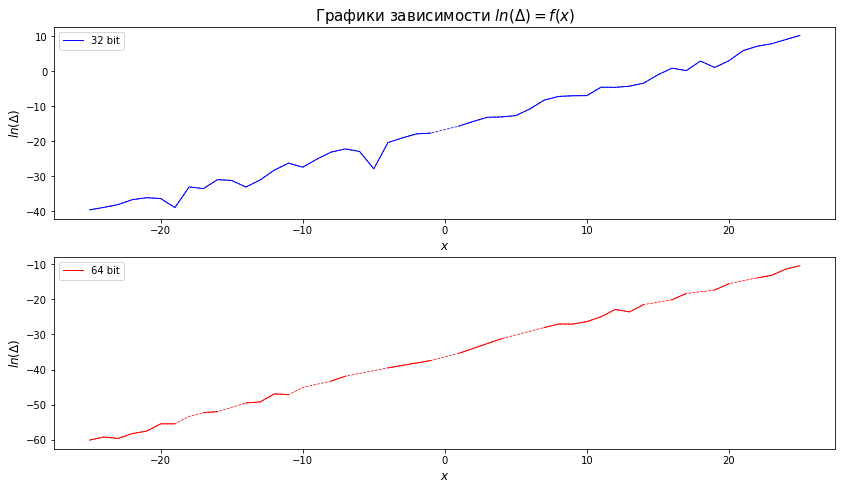

In [149]:
plt.figure(figsize=(14,12))
xs = df['x'].values

ax1 = plt.subplot(311)
sort = sorted(zip(df['DELTA_32'].apply(np.log).values, xs), key=lambda x: x[1])
xs = [x[1] for x in sort]
ys = [x[0] for x in sort]
plt.plot(xs, ys, c='b', lw=1, label='32 bit');
plt.legend()
plt.title('Графики зависимости $ln(\Delta) = f(x)$', fontsize=15)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$ln(\Delta)$', fontsize=12)
plt.plot(xs, smooth_infty(ys), 'k--', c='b', lw=0.75);

ax1 = plt.subplot(312)
sort = sorted(zip(df['DELTA_64'].apply(np.log).values, xs), key=lambda x: x[1])
xs = [x[1] for x in sort]
ys = [x[0] for x in sort]
plt.plot(xs, ys, c='r', lw=1, label='64 bit');
plt.legend()
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$ln(\Delta)$', fontsize=12)
plt.plot(xs, smooth_infty(ys), 'k--', c='r', lw=0.75);

Исходя из очевидного тренда линейности данных графиков, можно отметить, что абсолютная ошибка растет экспоненциально аналогично самой функции, выбросы практически отсутствуют или несущественны. Реализованный метод стабилен для элементов отрезка $[-25, 25]$.

### Выводы:
1. Исходный метод суммирования дает приемлемый результат при $x>0$ и не применим в случаях $x<0$, так как имеет место проблема сложения сравнимых по величине и отличных по знаку чисел, что приводит к существенному росту погрешности; 
2. Модернизированный метод решает данную проблему путем вычисления суммы положительного ряда и последующего его обращения: $$e^{-x} = \frac{1}{e^x} = \frac{1}{\sum \limits_{i=0}^{\infty}\frac{x^k}{k!}}, \, x>0$$
3. Модернизированный метод применялся для разных архитектур мантиссы: 32, 64, 128 бит. Отмечено, что реализованный модернизированный метод в случае 128-битного представления эквивалентен встроенному методу вычисления экспоненты; 